In [20]:
import os
from copy import deepcopy
from itertools import tee
import matplotlib.pyplot as plt

from river import metrics, preprocessing, ensemble
from river.drift import ADWIN
from river.datasets import synth

# If not already defined, import or implement this
# from your_module import ARFRegressorDynamicWeights

# --------------------------
# ARFF Export Function
# --------------------------


def save_stream_to_arff(stream, relation_name="agrawal_stream", output_file="agrawal_stream.arff"):
    stream = list(stream)  # Unpack the stream to inspect
    if not stream:
        raise ValueError("Stream is empty")

    x_example, _ = stream[0]
    feature_names = list(x_example.keys())
    class_labels = sorted(set(y for _, y in stream))

    with open(output_file, "w") as f:
        # Header
        f.write(f"@RELATION {relation_name}\n\n")

        for feat in feature_names:
            f.write(f"@ATTRIBUTE {feat} NUMERIC\n")  # You can customize this if needed

        f.write(f"@ATTRIBUTE class {{{', '.join(map(str, class_labels))}}}\n\n")
        f.write("@DATA\n")

        # Data rows
        for x, y in stream:
            values = [str(x[feat]) for feat in feature_names]
            values.append(str(y))
            f.write(",".join(values) + "\n")

    print(f"Stream saved to {output_file} in ARFF format.")

# Usage
# stream = deepcopy(synth.Agrawal()).take(1000)
# save_stream_to_arff(stream)

# --------------------------
# Dataset Definitions
# --------------------------
regression_datasets = [
    ("friedman", synth.Friedman(seed=1).take(100000)),
    ("friedman_drift", synth.FriedmanDrift(seed=1).take(100000)),
    ("mv", synth.Mv(seed=1).take(100000)),
    ("planes2d", synth.Planes2D(seed=1).take(100000))
]

multi_output_binary_classification_datasets = [
    ("logical", synth.Logical(seed=1).take(100000))
]

# --------------------------
# Evaluate Function
# --------------------------
from itertools import tee

def evaluate_regression_stream(name, stream):
    stream_std, stream_dyn = tee(stream, 2)  # ✅ Do NOT deepcopy

    model_std = (
        preprocessing.StandardScaler() |
        forest.ARFRegressor(
            n_models=10,
            seed=42,
            lambda_value=6,
            grace_period=50,
            leaf_prediction="adaptive"
        )
    )

    model_dyn = ARFRegressorDynamicWeights(
        n_models=10,
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive",
        metric=metrics.MAE(),
        drift_detector=ADWIN(delta=0.001),
        warning_detector=ADWIN(delta=0.01),
        error_threshold_factor=0.2
    )

    metric_std = metrics.MAE()
    metric_dyn = metrics.MAE()

    std_mae, dyn_mae = [], []

    for x, y in stream_std:
        y_pred = model_std.predict_one(x)
        if y_pred is not None:
            metric_std.update(y, y_pred)
        model_std.learn_one(x, y)
        std_mae.append(metric_std.get())

    for x, y in stream_dyn:
        y_pred = model_dyn.predict_one(x)
        if y_pred is not None:
            metric_dyn.update(y, y_pred)
        model_dyn.learn_one(x, y)
        dyn_mae.append(metric_dyn.get())

    print(f"📊 [{name.upper()}] Final MAE → Standard: {metric_std.get():.4f}, Dynamic: {metric_dyn.get():.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(std_mae, label=f"Standard ARF (MAE: {metric_std.get():.3f})")
    plt.plot(dyn_mae, label=f"Dynamic ARF (MAE: {metric_dyn.get():.3f})")
    plt.title(f"Regression: {name}")
    plt.xlabel("Instances Seen")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------------------------
# Run Evaluation + ARFF Export
# --------------------------

output_dir = "arff_exports"
os.makedirs(output_dir, exist_ok=True)

# 1. Regression Datasets
for name, stream in regression_datasets:
    stream_eval, stream_arff = tee(stream, 2)  # Avoid deepcopy, use tee
    evaluate_regression_stream(name, stream_eval)
    save_stream_to_arff(
        stream_arff,
        relation_name=name,
        output_file=os.path.join(output_dir, f"{name}.arff")
    )


# 2. Multi-output Binary Classification Datasets
for name, stream in multi_output_binary_classification_datasets:
    stream_arff = tee(stream, 1)[0]
    save_stream_to_arff(
        stream_arff,
        relation_name=name,
        output_file=os.path.join(output_dir, f"{name}.arff")
    )


KeyboardInterrupt: 

In [1]:
from __future__ import annotations

import abc
import collections
import copy
import math
import random
import typing

import numpy as np

from river import base, metrics, stats
from river.drift import ADWIN, NoDrift
# HoeffdingTreeClassifier and arf_htc_nodes are not needed for regressor
from river.tree.hoeffding_tree_regressor import HoeffdingTreeRegressor
from river.tree.nodes.arf_htr_nodes import RandomLeafAdaptive, RandomLeafMean, RandomLeafModel
from river.tree.splitter import Splitter
from river.utils.random import poisson


# ================================================================
# COPIED BaseForest, BaseTreeRegressor for context
# (Minor adjustments in BaseForest for clarity in the derived regressor)
# ================================================================
class BaseForest(base.Ensemble):
    _FEATURES_SQRT = "sqrt"
    _FEATURES_LOG2 = "log2"

    def __init__(
        self,
        n_models: int,
        max_features: bool | str | int,
        lambda_value: int,
        drift_detector: base.DriftDetector,
        warning_detector: base.DriftDetector,
        metric: metrics.base.MultiClassMetric | metrics.base.RegressionMetric, # Type hint is fine
        disable_weighted_vote, # Keep this parameter
        seed,
    ):
        super().__init__([])  # type: ignore
        self.n_models = n_models
        self.max_features = max_features
        self.lambda_value = lambda_value
        self.metric = metric # Standard metric, used for drift/warning
        self.disable_weighted_vote = disable_weighted_vote
        self.drift_detector = drift_detector
        self.warning_detector = warning_detector
        self.seed = seed

        self._rng = random.Random(self.seed)

        self._warning_detectors: list[base.DriftDetector]
        self._warning_detection_disabled = True
        if not isinstance(self.warning_detector, NoDrift):
            self._warning_detectors = [self.warning_detector.clone() for _ in range(self.n_models)]
            self._warning_detection_disabled = False

        self._drift_detectors: list[base.DriftDetector]
        self._drift_detection_disabled = True
        if not isinstance(self.drift_detector, NoDrift):
            self._drift_detectors = [self.drift_detector.clone() for _ in range(self.n_models)]
            self._drift_detection_disabled = False

        # The background models
        self._background: list[HoeffdingTreeRegressor | None] = ( # More specific type for regressor
            None if self._warning_detection_disabled else [None] * self.n_models  # type: ignore
        )

        # Performance metrics used for weighted voting/aggregation (Standard way)
        self._metrics = [self.metric.clone() for _ in range(self.n_models)]

        # Drift and warning logging
        self._warning_tracker: dict = (
            collections.defaultdict(int) if not self._warning_detection_disabled else None  # type: ignore
        )
        self._drift_tracker: dict = (
            collections.defaultdict(int) if not self._drift_detection_disabled else None  # type: ignore
        )

    @property
    def _min_number_of_models(self):
        return 0

    @classmethod
    def _unit_test_params(cls):
        yield {"n_models": 3}

    def _unit_test_skips(self):
        return {"check_shuffle_features_no_impact"}

    @abc.abstractmethod
    def _drift_detector_input(
        self,
        tree_id: int,
        y_true,
        y_pred,
    ) -> int | float:
        raise NotImplementedError

    @abc.abstractmethod
    def _new_base_model(self) -> HoeffdingTreeRegressor: # Specific to Regressor
        raise NotImplementedError

    def n_warnings_detected(self, tree_id: int | None = None) -> int:
        if self._warning_detection_disabled: return 0
        if tree_id is None: return sum(self._warning_tracker.values())
        return self._warning_tracker[tree_id]

    def n_drifts_detected(self, tree_id: int | None = None) -> int:
        if self._drift_detection_disabled: return 0
        if tree_id is None: return sum(self._drift_tracker.values())
        return self._drift_tracker[tree_id]

    def learn_one(self, x: dict, y: base.typing.Target, **kwargs):
         if len(self) == 0:
             self._init_ensemble(sorted(x.keys()))

         for i, model in enumerate(self):
             y_pred = model.predict_one(x)

             # Update standard performance evaluator (for drift/warning)
             # For regressors, predict_proba_one doesn't exist/apply like in classifiers
             self._metrics[i].update(y_true=y, y_pred=y_pred)


             # Original drift/warning logic
             drift_input = None
             if not self._warning_detection_disabled:
                 drift_input = self._drift_detector_input(i, y, y_pred)
                 self._warning_detectors[i].update(drift_input)
                 if self._warning_detectors[i].drift_detected:
                     if self._background is not None:
                         self._background[i] = self._new_base_model()
                     self._warning_detectors[i] = self.warning_detector.clone()
                     self._warning_tracker[i] += 1

             if not self._drift_detection_disabled:
                 drift_input = (
                     drift_input
                     if drift_input is not None
                     else self._drift_detector_input(i, y, y_pred)
                 )
                 self._drift_detectors[i].update(drift_input)
                 if self._drift_detectors[i].drift_detected:
                     if not self._warning_detection_disabled and self._background is not None and self._background[i] is not None:
                         self.data[i] = self._background[i]
                         self._background[i] = None
                     else:
                         self.data[i] = self._new_base_model()

                     if not self._warning_detection_disabled:
                        self._warning_detectors[i] = self.warning_detector.clone()
                     self._drift_detectors[i] = self.drift_detector.clone()
                     self._metrics[i] = self.metric.clone()
                     # *** DYNAMIC WEIGHTS RESET WILL BE HANDLED IN DERIVED CLASS ***
                     self._drift_tracker[i] += 1

             k = poisson(rate=self.lambda_value, rng=self._rng)
             if k > 0:
                 if not self._warning_detection_disabled and self._background is not None and self._background[i] is not None:
                    self._background[i].learn_one(x=x, y=y, w=k) # type: ignore
                 model.learn_one(x=x, y=y, w=k)


    def _init_ensemble(self, features: list):
        self._set_max_features(len(features))
        self.data = [self._new_base_model() for _ in range(self.n_models)]
        # *** DYNAMIC WEIGHTS INIT WILL BE HANDLED IN DERIVED CLASS ***

    def _set_max_features(self, n_features):
        if self.max_features == "sqrt": self.max_features = round(math.sqrt(n_features))
        elif self.max_features == "log2": self.max_features = round(math.log2(n_features))
        elif isinstance(self.max_features, int): pass
        elif isinstance(self.max_features, float): self.max_features = int(self.max_features * n_features)
        elif self.max_features is None: self.max_features = n_features
        else: raise AttributeError(f"Invalid max_features: {self.max_features}...")
        if self.max_features < 0: self.max_features += n_features
        if self.max_features <= 0: self.max_features = 1
        if self.max_features > n_features: self.max_features = n_features

class BaseTreeRegressor(HoeffdingTreeRegressor):
    # (Copied as provided - No changes needed here)
    def __init__( self, max_features: int = 2, grace_period: int = 200, max_depth: int | None = None,
        delta: float = 1e-7, tau: float = 0.05, leaf_prediction: str = "adaptive",
        leaf_model: base.Regressor | None = None, model_selector_decay: float = 0.95,
        nominal_attributes: list | None = None, splitter: Splitter | None = None,
        min_samples_split: int = 5, binary_split: bool = False, max_size: float = 100.0,
        memory_estimate_period: int = 1000000, stop_mem_management: bool = False,
        remove_poor_attrs: bool = False, merit_preprune: bool = True,
        rng: random.Random | None = None,
    ):
        super().__init__(
            grace_period=grace_period, max_depth=max_depth, delta=delta, tau=tau,
            leaf_prediction=leaf_prediction, leaf_model=leaf_model,
            model_selector_decay=model_selector_decay, nominal_attributes=nominal_attributes,
            splitter=splitter, min_samples_split=min_samples_split, binary_split=binary_split,
            max_size=max_size, memory_estimate_period=memory_estimate_period,
            stop_mem_management=stop_mem_management, remove_poor_attrs=remove_poor_attrs,
            merit_preprune=merit_preprune,
        )
        self.max_features = max_features
        self.rng = rng

    def _new_leaf(self, initial_stats=None, parent=None):  # noqa
        if parent is not None: depth = parent.depth + 1
        else: depth = 0
        leaf_model = None
        if self.leaf_prediction in {self._MODEL, self._ADAPTIVE}:
            if parent is None: leaf_model = copy.deepcopy(self.leaf_model)
            else:
                try: leaf_model = copy.deepcopy(parent._leaf_model)  # noqa
                except AttributeError: leaf_model = copy.deepcopy(self.leaf_model)
        if self.leaf_prediction == self._TARGET_MEAN:
            return RandomLeafMean(initial_stats, depth, self.splitter, self.max_features, self.rng)
        elif self.leaf_prediction == self._MODEL:
            return RandomLeafModel(initial_stats, depth, self.splitter, self.max_features, self.rng, leaf_model=leaf_model)
        else:  # adaptive learning node
            new_adaptive = RandomLeafAdaptive(initial_stats, depth, self.splitter, self.max_features, self.rng, leaf_model=leaf_model)
            if parent is not None and isinstance(parent, RandomLeafAdaptive):
                new_adaptive._fmse_mean = parent._fmse_mean; new_adaptive._fmse_model = parent._fmse_model
            return new_adaptive

# ================================================================
# Original ARFRegressor - We will inherit from this
# ================================================================
class ARFRegressor(BaseForest, base.Regressor):
    """Adaptive Random Forest regressor. (Original Docstring)"""
    _MEAN = "mean"
    _MEDIAN = "median"
    _VALID_AGGREGATION_METHOD = [_MEAN, _MEDIAN]

    def __init__(
        self, n_models: int = 10, max_features="sqrt", aggregation_method: str = "median",
        lambda_value: int = 6, metric: metrics.base.RegressionMetric | None = None,
        disable_weighted_vote=True, drift_detector: base.DriftDetector | None = None,
        warning_detector: base.DriftDetector | None = None, grace_period: int = 50,
        max_depth: int | None = None, delta: float = 0.01, tau: float = 0.05,
        leaf_prediction: str = "adaptive", leaf_model: base.Regressor | None = None,
        model_selector_decay: float = 0.95, nominal_attributes: list | None = None,
        splitter: Splitter | None = None, min_samples_split: int = 5, binary_split: bool = False,
        max_size: float = 500.0, memory_estimate_period: int = 2_000_000,
        stop_mem_management: bool = False, remove_poor_attrs: bool = False,
        merit_preprune: bool = True, seed: int | None = None,
    ):
        super().__init__(
            n_models=n_models, max_features=max_features, lambda_value=lambda_value,
            metric=metric or metrics.MSE(), disable_weighted_vote=disable_weighted_vote,
            drift_detector=drift_detector or ADWIN(0.001),
            warning_detector=warning_detector or ADWIN(0.01), seed=seed,
        )
        self.grace_period=grace_period; self.max_depth=max_depth; self.delta=delta; self.tau=tau
        self.leaf_prediction=leaf_prediction; self.leaf_model=leaf_model
        self.model_selector_decay=model_selector_decay; self.nominal_attributes=nominal_attributes
        self.splitter=splitter; self.min_samples_split=min_samples_split; self.binary_split=binary_split
        self.max_size=max_size; self.memory_estimate_period=memory_estimate_period
        self.stop_mem_management=stop_mem_management; self.remove_poor_attrs=remove_poor_attrs
        self.merit_preprune=merit_preprune
        if aggregation_method in self._VALID_AGGREGATION_METHOD: self.aggregation_method = aggregation_method
        else: raise ValueError(f"Invalid aggregation_method...")
        self._drift_norm = [stats.Var() for _ in range(self.n_models)]

    @property
    def _mutable_attributes(self): return {"max_features", "aggregation_method", "lambda_value",
                                          "grace_period", "delta", "tau", "model_selector_decay"}

    def predict_one(self, x: dict) -> base.typing.RegTarget:
        if len(self) == 0:
            self._init_ensemble(sorted(x.keys()))
            return 0.0  # type: ignore
        y_pred_values = np.zeros(self.n_models) # Stores individual tree predictions
        if not self.disable_weighted_vote and self.aggregation_method != self._MEDIAN:
            # Original weighting based on inverse of standard metric (e.g., MSE)
            weights = np.zeros(self.n_models)
            sum_metric_values = 0.0
            for i, model in enumerate(self):
                y_pred_values[i] = model.predict_one(x)
                metric_val = self._metrics[i].get()
                # MSE: lower is better. We want to give higher weight to lower MSE.
                # So, if metric_val is small, its weight should be large.
                # The original logic `sum_weights - weights` (where weights=metric_val) achieves this.
                weights[i] = metric_val
                sum_metric_values += metric_val

            if sum_metric_values != 0: # Avoid division by zero if all metrics are 0
                # Invert: higher error -> lower contribution
                # (sum_metric_values - weights[j]) is large if weights[j] (error) is small
                final_weights = sum_metric_values - weights
                sum_final_weights = final_weights.sum()
                if sum_final_weights > 0 :
                    final_weights /= sum_final_weights # Normalize
                    y_pred_aggregate = np.sum(y_pred_values * final_weights)
                else: # all trees have max error or sum is zero for other reasons
                    y_pred_aggregate = y_pred_values.mean()
            else: # All metrics are zero (perfect predictions or no updates yet)
                y_pred_aggregate = y_pred_values.mean()
        else: # No weighting or median aggregation
            for i, model in enumerate(self):
                y_pred_values[i] = model.predict_one(x)
            if self.aggregation_method == self._MEAN:
                y_pred_aggregate = y_pred_values.mean()
            else: # MEDIAN
                y_pred_aggregate = float(np.median(y_pred_values))
        return float(y_pred_aggregate)

    def _new_base_model(self):
        return BaseTreeRegressor(
            max_features=self.max_features, grace_period=self.grace_period, max_depth=self.max_depth,
            delta=self.delta, tau=self.tau, leaf_prediction=self.leaf_prediction, leaf_model=self.leaf_model,
            model_selector_decay=self.model_selector_decay, nominal_attributes=self.nominal_attributes,
            splitter=self.splitter, binary_split=self.binary_split, max_size=self.max_size,
            memory_estimate_period=self.memory_estimate_period, stop_mem_management=self.stop_mem_management,
            remove_poor_attrs=self.remove_poor_attrs, merit_preprune=self.merit_preprune, rng=self._rng,
        )

    def _drift_detector_input( self, tree_id: int, y_true: int | float, y_pred: int | float, ) -> int | float:
        drift_input = y_true - y_pred
        self._drift_norm[tree_id].update(drift_input)
        if self._drift_norm[tree_id].mean.n == 1: return 0.5
        sd = math.sqrt(self._drift_norm[tree_id].get())
        return (drift_input + 3 * sd) / (6 * sd) if sd > 0 else 0.5

    @property
    def valid_aggregation_method(self): return self._VALID_AGGREGATION_METHOD


# ================================================================
# NEW Class ARFRegressorDynamicWeights
# ================================================================
class ARFRegressorDynamicWeights(ARFRegressor):
    """
    Adaptive Random Forest Regressor with dynamic tree weighting.

    This class modifies the weighting scheme of ARFRegressor.
    It maintains a performance score for each tree, updated based on the
    absolute error of its prediction. A smaller error leads to a score
    multiplied by 0.9 (better), while a larger error (above a threshold)
    leads to a score multiplied by 1.1 (worse).

    The final prediction is a weighted average of individual tree predictions,
    where weights are inversely derived from these dynamic scores.

    The `error_threshold_factor` parameter (default 0.1) defines how much
    the absolute error can deviate from a running mean absolute error before
    being penalized. If abs_error <= (1 + factor) * mean_abs_error, it's considered "good".

    Note:
    - The `disable_weighted_vote` parameter is effectively ignored.
    - The `aggregation_method` is always 'mean' with these dynamic weights.
      Median aggregation is not directly compatible with this weighting.
    - The `metric` parameter (e.g., MSE) is still used for drift/warning.
    """

    def __init__(self, *args, error_threshold_factor: float = 0.1, **kwargs):
        # Ensure aggregation_method is compatible or override it for dynamic weights
        # If we are doing custom weighted mean, 'median' is not applicable.
        if 'aggregation_method' in kwargs and kwargs['aggregation_method'] == self._MEDIAN:
            print(f"Warning: aggregation_method='{self._MEDIAN}' is not compatible with "
                  "ARFRegressorDynamicWeights. Using weighted mean.")
        kwargs['aggregation_method'] = self._MEAN # Force mean for our weighted approach
        # The `disable_weighted_vote` flag will be effectively true for the parent's
        # weighting logic, as we implement our own.
        kwargs['disable_weighted_vote'] = True # Parent's weighting is off

        super().__init__(*args, **kwargs)

        self.error_threshold_factor = error_threshold_factor

        # Dynamic weighting attributes
        self._dynamic_perf_scores: list[float] = []
        self._dynamic_weights: list[float] = []
        # To track a running average of absolute errors for thresholding
        self._mean_abs_errors: list[stats.Mean] = []


        if len(self) > 0: # If models already exist (e.g. loaded)
            self._init_dynamic_weights()

    def _init_dynamic_weights(self):
        """Initializes dynamic weight tracking lists."""
        self._dynamic_perf_scores = [1.0] * self.n_models # Neutral score
        equal_weight = 1.0 / self.n_models if self.n_models > 0 else 1.0
        self._dynamic_weights = [equal_weight] * self.n_models
        self._mean_abs_errors = [stats.Mean() for _ in range(self.n_models)]

    def _init_ensemble(self, features: list):
        """Overrides base to include dynamic weights initialization."""
        super()._init_ensemble(features)
        self._init_dynamic_weights()

    def _update_dynamic_weights(self):
        """Calculates normalized weights from performance scores."""
        if not self._dynamic_perf_scores: return

        raw_weights = [1.0 / (1.0 + score) for score in self._dynamic_perf_scores]
        total_weight = sum(raw_weights)

        if total_weight > 0:
            self._dynamic_weights = [w / total_weight for w in raw_weights]
        else:
            equal_weight = 1.0 / self.n_models if self.n_models > 0 else 1.0
            self._dynamic_weights = [equal_weight] * self.n_models

    def learn_one(self, x: dict, y: base.typing.RegTarget, **kwargs):
        """
        Learns from an instance, updates dynamic performance scores for regression,
        and recalculates weights.
        """
        if len(self) == 0:
            self._init_ensemble(sorted(x.keys()))

        tree_predictions = [0.0] * self.n_models

        # --- Stage 1: Predictions and Metric Updates ---
        for i, model in enumerate(self):
            y_pred_tree = model.predict_one(x)
            tree_predictions[i] = y_pred_tree

            # Update standard metric (e.g., MSE) for drift/warning
            self._metrics[i].update(y_true=y, y_pred=y_pred_tree)

            # Update dynamic performance score for regression
            abs_error = abs(y - y_pred_tree)
            self._mean_abs_errors[i].update(abs_error)
            current_mean_abs_error = self._mean_abs_errors[i].get()

            # Define a threshold for "good" vs "bad" prediction based on running MAE
            # Avoid issues if current_mean_abs_error is 0 or very small initially
            if current_mean_abs_error > 1e-9: # Check if MAE is somewhat established
                error_bound = current_mean_abs_error * (1 + self.error_threshold_factor)
            else: # If MAE is tiny/zero, any error is relatively large, or no error is good.
                  # Set a small absolute bound or simply check if error is non-zero
                error_bound = self.error_threshold_factor * 0.1 # A small arbitrary value initially

            if abs_error <= error_bound:
                self._dynamic_perf_scores[i] *= 0.9  # Good prediction (small error)
            else:
                self._dynamic_perf_scores[i] *= 1.1  # Bad prediction (large error)

            # Optional: Bound scores
            # self._dynamic_perf_scores[i] = max(0.01, min(self._dynamic_perf_scores[i], 100.0))

        # --- Stage 2: Drift/Warning Detection and Tree Management ---
        for i, model in enumerate(self):
            y_pred_tree = tree_predictions[i]
            drift_input = None

            if not self._warning_detection_disabled:
                drift_input = self._drift_detector_input(i, y, y_pred_tree)
                self._warning_detectors[i].update(drift_input)
                if self._warning_detectors[i].drift_detected:
                    if self._background is not None:
                        self._background[i] = self._new_base_model()
                    self._warning_detectors[i] = self.warning_detector.clone()
                    self._warning_tracker[i] += 1

            if not self._drift_detection_disabled:
                drift_input = (drift_input if drift_input is not None
                               else self._drift_detector_input(i, y, y_pred_tree))
                self._drift_detectors[i].update(drift_input)
                if self._drift_detectors[i].drift_detected:
                    if not self._warning_detection_disabled and self._background is not None and self._background[i] is not None:
                        self.data[i] = self._background[i]
                        self._background[i] = None
                    else:
                        self.data[i] = self._new_base_model()

                    if not self._warning_detection_disabled:
                        self._warning_detectors[i] = self.warning_detector.clone()
                    self._drift_detectors[i] = self.drift_detector.clone()
                    self._metrics[i] = self.metric.clone() # Reset standard metric

                    # Reset dynamic score and MAE tracker for the new tree
                    self._dynamic_perf_scores[i] = 1.0
                    self._mean_abs_errors[i] = stats.Mean() # Reset MAE tracker

                    self._drift_tracker[i] += 1

        # --- Stage 3: Recalculate Weights and Train Models ---
        self._update_dynamic_weights()

        for i, model in enumerate(self):
            k = poisson(rate=self.lambda_value, rng=self._rng)
            if k > 0:
                if not self._warning_detection_disabled and self._background is not None and self._background[i] is not None:
                    self._background[i].learn_one(x=x, y=y, w=k) # type: ignore
                model.learn_one(x=x, y=y, w=k)

    # Override predict_one to use the new dynamic weights
    def predict_one(self, x: dict) -> base.typing.RegTarget:
        """
        Predicts a target value using dynamically weighted averaging.
        """
        if len(self) == 0:
            self._init_ensemble(sorted(x.keys()))
            return 0.0 # Default prediction for uninitialized model

        if not self._dynamic_weights: # Should be initialized by _init_ensemble or constructor
            self._init_dynamic_weights()

        weighted_sum_predictions = 0.0
        sum_of_weights = 0.0 # Should be 1 if weights are normalized, but good for robustness

        for i, model in enumerate(self):
            y_pred_tree = model.predict_one(x)
            weight = self._dynamic_weights[i]

            if weight > 0: # Only consider trees with positive weight
                weighted_sum_predictions += y_pred_tree * weight
                sum_of_weights += weight

        if sum_of_weights > 0:
            return float(weighted_sum_predictions / sum_of_weights) # Normalize if sum_of_weights != 1
        else:
            # All weights are zero, fall back to simple average or default
            # This case should be rare if scores don't all become infinite
            if self.n_models > 0:
                fallback_sum = 0.0
                for model_fb in self:
                    fallback_sum += model_fb.predict_one(x)
                return float(fallback_sum / self.n_models)
            return 0.0 # Default if no models


📊 [FRIEDMAN]
Standard ARF: MAE=1.6462, R2=0.8201
Dynamic  ARF: MAE=1.4795, R2=0.8530


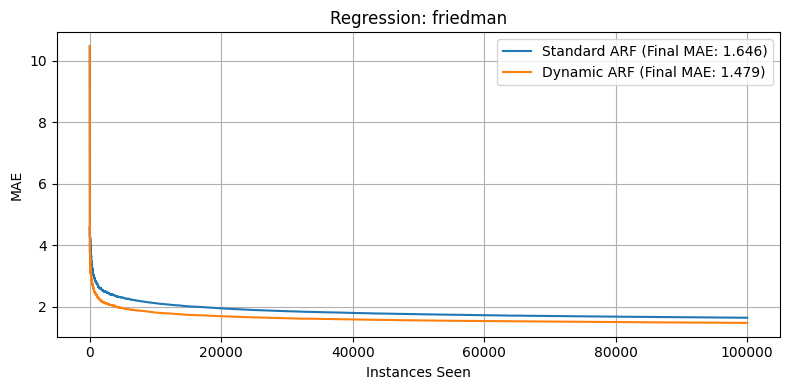

✅ Saved ARFF: arff_exports/friedman.arff

📊 [FRIEDMAN_DRIFT]
Standard ARF: MAE=1.6985, R2=0.8034
Dynamic  ARF: MAE=1.5326, R2=0.8367


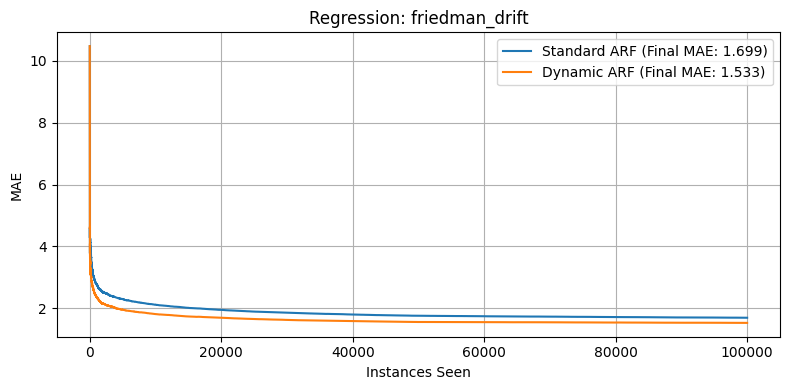

✅ Saved ARFF: arff_exports/friedman_drift.arff


TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [3]:
import os
import csv
from itertools import tee
import matplotlib.pyplot as plt

from river import metrics, preprocessing, ensemble, forest
from river.drift import ADWIN
from river.datasets import synth

# --------------------------
# ARFF Export Function
# --------------------------
def save_stream_to_arff(stream, relation_name="stream", output_file="stream.arff"):
    stream = list(stream)
    if not stream:
        raise ValueError("Stream is empty")

    x_example, _ = stream[0]
    feature_names = list(x_example.keys())
    class_labels = sorted(set(y for _, y in stream))

    with open(output_file, "w") as f:
        f.write(f"@RELATION {relation_name}\n\n")
        for feat in feature_names:
            f.write(f"@ATTRIBUTE {feat} NUMERIC\n")
        f.write(f"@ATTRIBUTE class {{{', '.join(map(str, class_labels))}}}\n\n")
        f.write("@DATA\n")
        for x, y in stream:
            values = [str(x[feat]) for feat in feature_names]
            values.append(str(y))
            f.write(",".join(values) + "\n")
    print(f"✅ Saved ARFF: {output_file}")

# --------------------------
# Dataset Definitions
# --------------------------
regression_datasets = [
    ("friedman", synth.Friedman(seed=1).take(100000)),
    ("friedman_drift", synth.FriedmanDrift(seed=1).take(100000)),
    ("mv", synth.Mv(seed=1).take(100000)),
    ("planes2d", synth.Planes2D(seed=1).take(100000))
]

# --------------------------
# Result CSV Setup
# --------------------------
csv_path = "regression_results.csv"
fieldnames = [
    "dataset", "model",
    "MAE", "RMSE", "R2", "MAPE"
]
if not os.path.exists(csv_path):
    with open(csv_path, mode="w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

# --------------------------
# Evaluation Function
# --------------------------
def evaluate_regression_stream(name, stream):
    stream_std, stream_dyn = tee(stream, 2)

    model_std = (
        preprocessing.StandardScaler() |
        forest.ARFRegressor(
            n_models=10,
            seed=42,
            lambda_value=6,
            grace_period=50,
            leaf_prediction="adaptive"
        )
    )

    model_dyn = ARFRegressorDynamicWeights(
        n_models=10,
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive",
        metric=metrics.MAE(),
        drift_detector=ADWIN(delta=0.001),
        warning_detector=ADWIN(delta=0.01),
        error_threshold_factor=0.2
    )

    # Metrics for both models
    metric_std_all = {
        "MAE": metrics.MAE(),
        "RMSE": metrics.RMSE(),
        "R2": metrics.R2(),
        "MAPE": metrics.MAPE()
    }
    metric_dyn_all = {
        "MAE": metrics.MAE(),
        "RMSE": metrics.RMSE(),
        "R2": metrics.R2(),
        "MAPE": metrics.MAPE()
    }

    std_mae, dyn_mae = [], []

    for x, y in stream_std:
        y_pred = model_std.predict_one(x)
        if y_pred is not None:
            for m in metric_std_all.values():
                m.update(y, y_pred)
        model_std.learn_one(x, y)
        std_mae.append(metric_std_all["MAE"].get())

    for x, y in stream_dyn:
        y_pred = model_dyn.predict_one(x)
        if y_pred is not None:
            for m in metric_dyn_all.values():
                m.update(y, y_pred)
        model_dyn.learn_one(x, y)
        dyn_mae.append(metric_dyn_all["MAE"].get())

    # Print
    print(f"\n📊 [{name.upper()}]")
    print(f"Standard ARF: MAE={metric_std_all['MAE'].get():.4f}, R2={metric_std_all['R2'].get():.4f}")
    print(f"Dynamic  ARF: MAE={metric_dyn_all['MAE'].get():.4f}, R2={metric_dyn_all['R2'].get():.4f}")

    # Save to CSV
    with open(csv_path, mode="a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writerow({
            "dataset": name,
            "model": "Standard ARF",
            **{k: f"{m.get():.4f}" for k, m in metric_std_all.items()}
        })
        writer.writerow({
            "dataset": name,
            "model": "Dynamic ARF",
            **{k: f"{m.get():.4f}" for k, m in metric_dyn_all.items()}
        })

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(std_mae, label=f"Standard ARF (Final MAE: {metric_std_all['MAE'].get():.3f})")
    plt.plot(dyn_mae, label=f"Dynamic ARF (Final MAE: {metric_dyn_all['MAE'].get():.3f})")
    plt.title(f"Regression: {name}")
    plt.xlabel("Instances Seen")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------------------------
# Run Evaluation + ARFF Export
# --------------------------
output_dir = "arff_exports"
os.makedirs(output_dir, exist_ok=True)

for name, stream in regression_datasets:
    stream_eval, stream_arff = tee(stream, 2)
    evaluate_regression_stream(name, stream_eval)
    save_stream_to_arff(
        stream_arff,
        relation_name=name,
        output_file=os.path.join(output_dir, f"{name}.arff")
    )

print(f"\n✅ All results saved to: {csv_path}")



📊 [PLANES2D]
Standard ARF: MAE=0.8552, R2=0.9401
Dynamic  ARF: MAE=0.8660, R2=0.9386


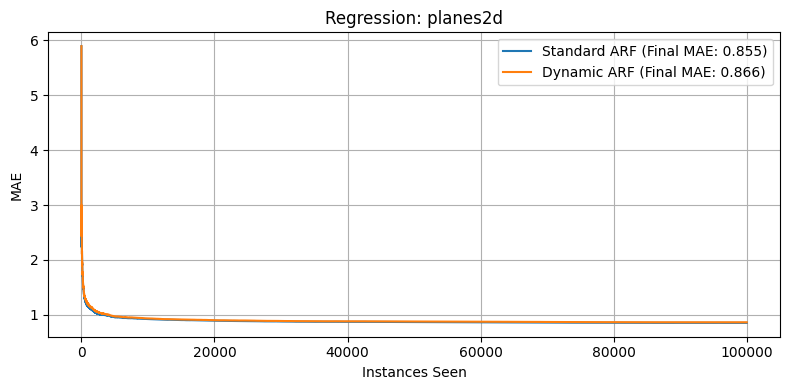

✅ Saved ARFF: arff_exports/planes2d.arff

✅ All results saved to: regression_results2.csv


In [5]:
import os
import csv
from itertools import tee
import matplotlib.pyplot as plt

from river import metrics, preprocessing, ensemble, forest
from river.drift import ADWIN
from river.datasets import synth

# --------------------------
# ARFF Export Function
# --------------------------
def save_stream_to_arff(stream, relation_name="stream", output_file="stream.arff"):
    stream = list(stream)
    if not stream:
        raise ValueError("Stream is empty")

    x_example, _ = stream[0]
    feature_names = list(x_example.keys())
    class_labels = sorted(set(y for _, y in stream))

    with open(output_file, "w") as f:
        f.write(f"@RELATION {relation_name}\n\n")
        for feat in feature_names:
            f.write(f"@ATTRIBUTE {feat} NUMERIC\n")
        f.write(f"@ATTRIBUTE class {{{', '.join(map(str, class_labels))}}}\n\n")
        f.write("@DATA\n")
        for x, y in stream:
            values = [str(x[feat]) for feat in feature_names]
            values.append(str(y))
            f.write(",".join(values) + "\n")
    print(f"✅ Saved ARFF: {output_file}")

# --------------------------
# Dataset Definitions
# --------------------------
regression_datasets = [
    ("planes2d", synth.Planes2D(seed=1).take(100000))
]

# --------------------------
# Result CSV Setup
# --------------------------
csv_path = "regression_results2.csv"
fieldnames = [
    "dataset", "model",
    "MAE", "RMSE", "R2", "MAPE"
]
if not os.path.exists(csv_path):
    with open(csv_path, mode="w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

# --------------------------
# Evaluation Function
# --------------------------
def evaluate_regression_stream(name, stream):
    stream_std, stream_dyn = tee(stream, 2)

    model_std =forest.ARFRegressor(
            n_models=10,
            seed=42,
            lambda_value=6,
            grace_period=50,
            leaf_prediction="adaptive"
        )

    model_dyn = ARFRegressorDynamicWeights(
        n_models=10,
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive",
        metric=metrics.MAE(),
        drift_detector=ADWIN(delta=0.001),
        warning_detector=ADWIN(delta=0.01),
        error_threshold_factor=0.2
    )

    # Metrics for both models
    metric_std_all = {
        "MAE": metrics.MAE(),
        "RMSE": metrics.RMSE(),
        "R2": metrics.R2(),
        "MAPE": metrics.MAPE()
    }
    metric_dyn_all = {
        "MAE": metrics.MAE(),
        "RMSE": metrics.RMSE(),
        "R2": metrics.R2(),
        "MAPE": metrics.MAPE()
    }

    std_mae, dyn_mae = [], []

    for x, y in stream_std:
        y_pred = model_std.predict_one(x)
        if y_pred is not None:
            for m in metric_std_all.values():
                m.update(y, y_pred)
        model_std.learn_one(x, y)
        std_mae.append(metric_std_all["MAE"].get())

    for x, y in stream_dyn:
        y_pred = model_dyn.predict_one(x)
        if y_pred is not None:
            for m in metric_dyn_all.values():
                m.update(y, y_pred)
        model_dyn.learn_one(x, y)
        dyn_mae.append(metric_dyn_all["MAE"].get())

    # Print
    print(f"\n📊 [{name.upper()}]")
    print(f"Standard ARF: MAE={metric_std_all['MAE'].get():.4f}, R2={metric_std_all['R2'].get():.4f}")
    print(f"Dynamic  ARF: MAE={metric_dyn_all['MAE'].get():.4f}, R2={metric_dyn_all['R2'].get():.4f}")

    # Save to CSV
    with open(csv_path, mode="a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writerow({
            "dataset": name,
            "model": "Standard ARF",
            **{k: f"{m.get():.4f}" for k, m in metric_std_all.items()}
        })
        writer.writerow({
            "dataset": name,
            "model": "Dynamic ARF",
            **{k: f"{m.get():.4f}" for k, m in metric_dyn_all.items()}
        })

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(std_mae, label=f"Standard ARF (Final MAE: {metric_std_all['MAE'].get():.3f})")
    plt.plot(dyn_mae, label=f"Dynamic ARF (Final MAE: {metric_dyn_all['MAE'].get():.3f})")
    plt.title(f"Regression: {name}")
    plt.xlabel("Instances Seen")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------------------------
# Run Evaluation + ARFF Export
# --------------------------
output_dir = "arff_exports"
os.makedirs(output_dir, exist_ok=True)

for name, stream in regression_datasets:
    stream_eval, stream_arff = tee(stream, 2)
    evaluate_regression_stream(name, stream_eval)
    save_stream_to_arff(
        stream_arff,
        relation_name=name,
        output_file=os.path.join(output_dir, f"{name}.arff")
    )

print(f"\n✅ All results saved to: {csv_path}")


In [11]:
from river import datasets
from river import evaluate
from river import forest
from river import ensemble
from river import metrics as river_metrics  # Alias to avoid conflict
from river import preprocessing
from river.drift import ADWIN

# Example Dataset
dataset = datasets.synth.Friedman(seed=42).take(2000)

# ---------------------------
# Baseline: Standard ARFRegressor
# ---------------------------
model_standard_arf = (
    preprocessing.StandardScaler() |
    forest.ARFRegressor(
        n_models=10,
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive"
    )
)

metric_standard = river_metrics.MAE()
print("Standard ARFRegressor:")
result_standard = evaluate.progressive_val_score(dataset, model_standard_arf, metric_standard)
print(result_standard)

# ---------------------------
# Advanced: ARFRegressorDynamicWeights
# ---------------------------
# Assuming ARFRegressorDynamicWeights is defined somewhere
model_dynamic_weights = ARFRegressorDynamicWeights(
    n_models=10,
    seed=42,
    lambda_value=6,
    grace_period=50,
    leaf_prediction="adaptive",
    metric=river_metrics.MAE(),
    drift_detector=ADWIN(delta=0.002),
    warning_detector=ADWIN(delta=0.005),
    error_threshold_factor=0.2
)

metric_dynamic = river_metrics.MAE()
print("\nARFRegressorDynamicWeights:")
result_dynamic = evaluate.progressive_val_score(dataset, model_dynamic_weights, metric_dynamic)
print(result_dynamic)


Standard ARFRegressor:
MAE: 2.718409

ARFRegressorDynamicWeights:
MAE: 0.


▶️  Evaluating Standard ARF…
  Step 500, MAE: 3.2656
  Step 1000, MAE: 2.9892
  Step 1500, MAE: 2.8554
  Step 2000, MAE: 2.7184
  Step 2500, MAE: 2.5718
  Step 3000, MAE: 2.4912
  Step 3500, MAE: 2.4343
  Step 4000, MAE: 2.3992
  Step 4500, MAE: 2.3606
  Step 5000, MAE: 2.3246
  Step 5500, MAE: 2.2954
  Step 6000, MAE: 2.2744
  Step 6500, MAE: 2.2520
  Step 7000, MAE: 2.2308
  Step 7500, MAE: 2.2092
  Step 8000, MAE: 2.1927
  Step 8500, MAE: 2.1688
  Step 9000, MAE: 2.1589
  Step 9500, MAE: 2.1468
  Step 10000, MAE: 2.1299
▶️  Evaluating Dynamic ARF with Weights…
  Step 500, MAE: 2.6160
  Step 1000, MAE: 2.3760
  Step 1500, MAE: 2.2447
  Step 2000, MAE: 2.1438
  Step 2500, MAE: 2.0406
  Step 3000, MAE: 2.0036
  Step 3500, MAE: 1.9660
  Step 4000, MAE: 1.9433
  Step 4500, MAE: 1.9199
  Step 5000, MAE: 1.9052
  Step 5500, MAE: 1.8866
  Step 6000, MAE: 1.8736
  Step 6500, MAE: 1.8599
  Step 7000, MAE: 1.8425
  Step 7500, MAE: 1.8270
  Step 8000, MAE: 1.8165
  Step 8500, MAE: 1.8026
  Step

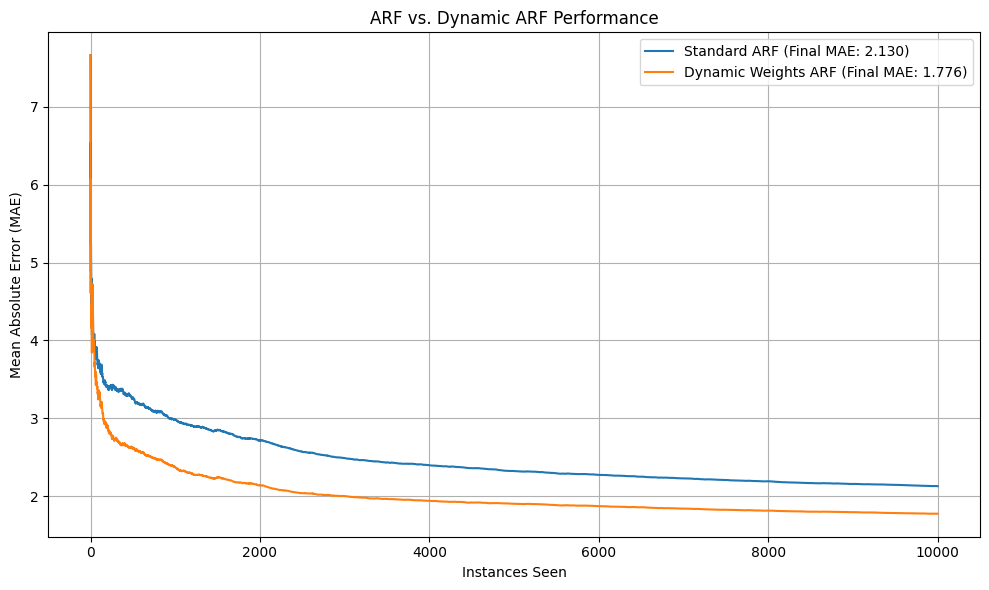

In [13]:
from river import datasets
from river import evaluate
from river import ensemble
from river import metrics
from river import preprocessing
from river.drift import ADWIN

import matplotlib.pyplot as plt
from itertools import tee

# Assuming you have implemented ARFRegressorDynamicWeights
# from your_module import ARFRegressorDynamicWeights

# 1. Create the dataset stream and copy it
dataset = datasets.synth.Friedman(seed=42).take(10000)
stream_standard, stream_dynamic = tee(dataset)

# 2. Define the models

# Standard ARF
model_standard = (
    preprocessing.StandardScaler() |
    forest.ARFRegressor(
        n_models=10,
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive"
    )
)

# Dynamic-weight ARF
model_dynamic = ARFRegressorDynamicWeights(
    n_models=10,
    seed=42,
    lambda_value=6,
    grace_period=50,
    leaf_prediction="adaptive",
    metric=metrics.MAE(),
    drift_detector=ADWIN(delta=0.002),
    warning_detector=ADWIN(delta=0.005),
    error_threshold_factor=0.2
)

# 3. Initialize metrics
metric_standard = metrics.MAE()
metric_dynamic = metrics.MAE()

standard_mae_history = []
dynamic_mae_history = []

# 4. Evaluate models on duplicated streams

# --- Standard ARF ---
print("▶️  Evaluating Standard ARF…")
for i, (x, y) in enumerate(stream_standard):
    y_pred = model_standard.predict_one(x)
    if y_pred is not None:
        metric_standard.update(y, y_pred)
    model_standard.learn_one(x, y)
    standard_mae_history.append(metric_standard.get())
    if (i + 1) % 500 == 0:
        print(f"  Step {i+1}, MAE: {metric_standard.get():.4f}")

# --- Dynamic Weights ARF ---
print("▶️  Evaluating Dynamic ARF with Weights…")
for i, (x, y) in enumerate(stream_dynamic):
    y_pred = model_dynamic.predict_one(x)
    if y_pred is not None:
        metric_dynamic.update(y, y_pred)
    model_dynamic.learn_one(x, y)
    dynamic_mae_history.append(metric_dynamic.get())
    if (i + 1) % 500 == 0:
        print(f"  Step {i+1}, MAE: {metric_dynamic.get():.4f}")

# 5. Final metrics
print("\n--- Final Results ---")
print(f"Standard ARF MAE: {metric_standard.get():.4f}")
print(f"Dynamic ARF MAE : {metric_dynamic.get():.4f}")

# 6. Plotting
plt.figure(figsize=(10, 6))
plt.plot(standard_mae_history, label=f"Standard ARF (Final MAE: {metric_standard.get():.3f})")
plt.plot(dynamic_mae_history, label=f"Dynamic Weights ARF (Final MAE: {metric_dynamic.get():.3f})")
plt.xlabel("Instances Seen")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("ARF vs. Dynamic ARF Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


▶️  Evaluating Standard ARF…
  Step 500, MAE: 3.2656
  Step 1000, MAE: 2.9892
  Step 1500, MAE: 2.8554
  Step 2000, MAE: 2.7184
  Step 2500, MAE: 2.5718
  Step 3000, MAE: 2.4912
  Step 3500, MAE: 2.4343
  Step 4000, MAE: 2.3992
  Step 4500, MAE: 2.3606
  Step 5000, MAE: 2.3246
  Step 5500, MAE: 2.2954
  Step 6000, MAE: 2.2744
  Step 6500, MAE: 2.2520
  Step 7000, MAE: 2.2308
  Step 7500, MAE: 2.2092
  Step 8000, MAE: 2.1927
  Step 8500, MAE: 2.1688
  Step 9000, MAE: 2.1589
  Step 9500, MAE: 2.1468
  Step 10000, MAE: 2.1299
▶️  Evaluating Dynamic ARF with Weights…
  Step 500, MAE: 2.6160
  Step 1000, MAE: 2.3760
  Step 1500, MAE: 2.2447
  Step 2000, MAE: 2.1438
  Step 2500, MAE: 2.0406
  Step 3000, MAE: 2.0036
  Step 3500, MAE: 1.9660
  Step 4000, MAE: 1.9433
  Step 4500, MAE: 1.9199
  Step 5000, MAE: 1.9052
  Step 5500, MAE: 1.8866
  Step 6000, MAE: 1.8736
  Step 6500, MAE: 1.8599
  Step 7000, MAE: 1.8425
  Step 7500, MAE: 1.8270
  Step 8000, MAE: 1.8165
  Step 8500, MAE: 1.8026
  Step

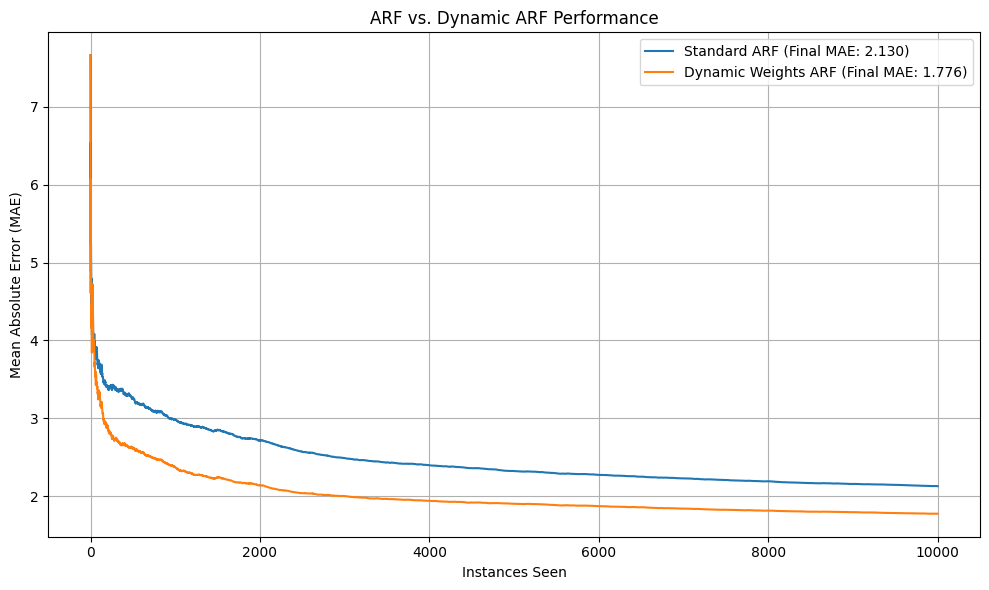

In [14]:
from river import datasets
from river import evaluate
from river import ensemble
from river import metrics
from river import preprocessing
from river.drift import ADWIN

import matplotlib.pyplot as plt
from itertools import tee

# Assuming you have implemented ARFRegressorDynamicWeights
# from your_module import ARFRegressorDynamicWeights

# 1. Create the dataset stream and copy it
dataset = datasets.synth.Friedman(seed=42).take(10000)
stream_standard, stream_dynamic = tee(dataset)

# 2. Define the models

# Standard ARF
model_standard = (
    preprocessing.StandardScaler() |
    forest.ARFRegressor(
        n_models=10,
        seed=42,
        lambda_value=6,
        grace_period=50,
        leaf_prediction="adaptive"
    )
)

# Dynamic-weight ARF
model_dynamic = ARFRegressorDynamicWeights(
    n_models=10,
    seed=42,
    lambda_value=6,
    grace_period=50,
    leaf_prediction="adaptive",
    metric=metrics.MAE(),
    drift_detector=ADWIN(delta=0.001),
    warning_detector=ADWIN(delta=0.01),
    error_threshold_factor=0.2
)

# 3. Initialize metrics
metric_standard = metrics.MAE()
metric_dynamic = metrics.MAE()

standard_mae_history = []
dynamic_mae_history = []

# 4. Evaluate models on duplicated streams

# --- Standard ARF ---
print("▶️  Evaluating Standard ARF…")
for i, (x, y) in enumerate(stream_standard):
    y_pred = model_standard.predict_one(x)
    if y_pred is not None:
        metric_standard.update(y, y_pred)
    model_standard.learn_one(x, y)
    standard_mae_history.append(metric_standard.get())
    if (i + 1) % 500 == 0:
        print(f"  Step {i+1}, MAE: {metric_standard.get():.4f}")

# --- Dynamic Weights ARF ---
print("▶️  Evaluating Dynamic ARF with Weights…")
for i, (x, y) in enumerate(stream_dynamic):
    y_pred = model_dynamic.predict_one(x)
    if y_pred is not None:
        metric_dynamic.update(y, y_pred)
    model_dynamic.learn_one(x, y)
    dynamic_mae_history.append(metric_dynamic.get())
    if (i + 1) % 500 == 0:
        print(f"  Step {i+1}, MAE: {metric_dynamic.get():.4f}")

# 5. Final metrics
print("\n--- Final Results ---")
print(f"Standard ARF MAE: {metric_standard.get():.4f}")
print(f"Dynamic ARF MAE : {metric_dynamic.get():.4f}")

# 6. Plotting
plt.figure(figsize=(10, 6))
plt.plot(standard_mae_history, label=f"Standard ARF (Final MAE: {metric_standard.get():.3f})")
plt.plot(dynamic_mae_history, label=f"Dynamic Weights ARF (Final MAE: {metric_dynamic.get():.3f})")
plt.xlabel("Instances Seen")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("ARF vs. Dynamic ARF Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
